# Chapter 14: Deep CV Using CNNs

In [1]:
# Libraries
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Seeds
np.random.seed(42)
tf.random.set_seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Overview

### 1.1 Motivation

Importance of parameter sharing!
- _e.g._ : 100x100 img $\to$ 10,000 pixels $\to$ 1,000 neurons in the first layer $\to$ 10 million params!!

### 1.2 Convolution

Pixel intensity is in $[0, 255]$ - scale features to get floats in $[0, 1]$

In [2]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

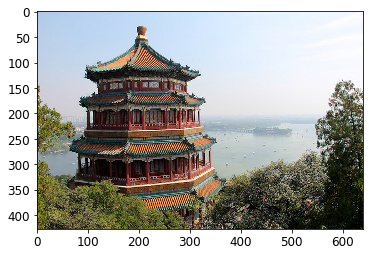

In [3]:
plt.imshow(china)

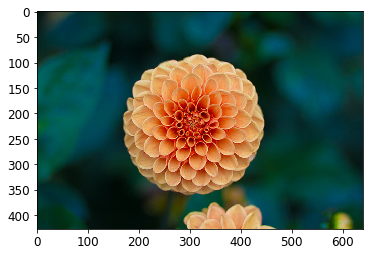

In [4]:
plt.imshow(flower)

Create two $7 \times 7$ filters:
- One with vertical white line
- Other with horizontal white line

In [5]:
# Create two filters
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

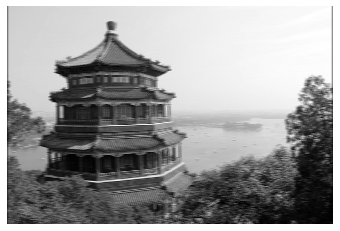

In [6]:
plt.imshow(outputs[0, :, :, 1], cmap = "gray") # plot 1st image's second feature map
plt.axis("off")
plt.show()

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

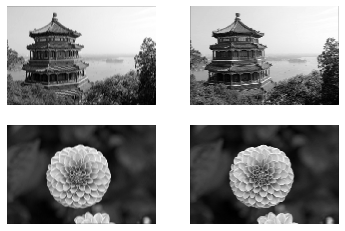

In [8]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])
        
plt.show()

In [9]:
def crop(images):
    return images[150:220, 130:250]

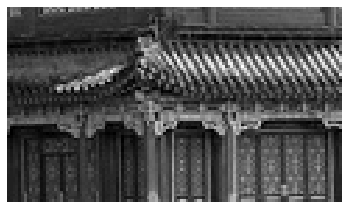

In [10]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

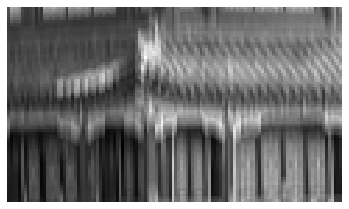

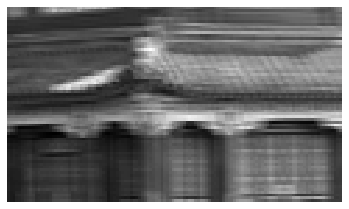

In [11]:
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

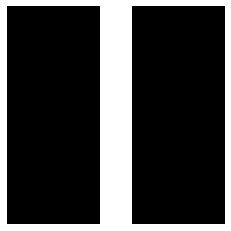

In [12]:
plot_image(filters[:, :, 0, 0])
plt.show()

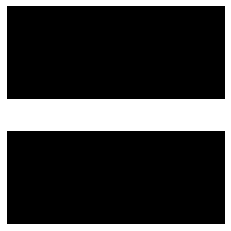

In [13]:
plot_image(filters[:, :, 0, 1])
plt.show()

### 1.3 Convolution layer review

`tf.nn.conv2d()` :
   - `images` : input mini-batch; 4D tensor
   - `filters` : set of filters to apply
   - `strides` : how to move the convolution
   - `padding` : one of `SAME` (use zero padding) or `VALID` (only uses what the image already provides)

In [14]:
# Example

conv = keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1,
                          padding = "same", activation = "relu")

### 1.4 VALID vs. SAME padding

In [15]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [16]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [17]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [18]:
kernel_size = 7
strides = 1

conv_valid = keras.layers.Conv2D(filters = 1, kernel_size = kernel_size, strides = strides, padding = "VALID")
conv_same = keras.layers.Conv2D(filters = 1, kernel_size = kernel_size, strides = strides, padding = "SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

In [19]:
# Call build() to create conv_same's weights
conv_same.build(tf.TensorShape(images.shape))

In [20]:
# Copy weights from conv_valid
conv_same.set_weights(conv_valid.get_weights())

In [21]:
same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## 2. Pooling Layer

### 2.1 Max pooling

Simple & common: take max input in kernel

__Pros__ :
- Reduce computations
- Reduce memory usage & parameters
- Some level of invariance to _small_ translations, rotations, and scale

__Cons__ :
- Destructive: even with tiny 2x2 kernel, output is halved in each dimension (4x smaller)
- Some applications don't want _invariance_ (small shift $\implies$ no output change) but rather _equivariance_ (small shift $\implies$ small output change)

In [22]:
max_pool = keras.layers.MaxPool2D(pool_size = 2) # uses VALID/no padding by default

In [23]:
cropped_images = np.array([crop(image) for image in images], dtype = np.float32)
output = max_pool(cropped_images)

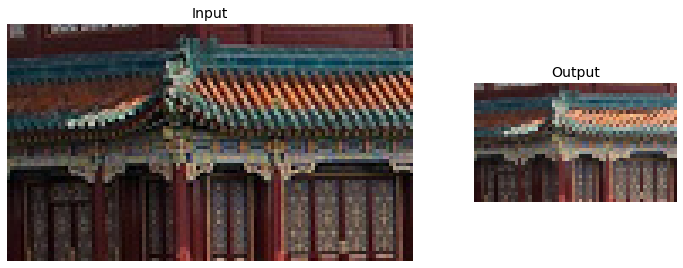

In [24]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### 2.2 Average pooling

Used to be popular, has since fallen out of favor
- Max pooling preserves only strongest features $\implies$ cleaner signal to subsequent layers
- Max pool also tends to perform better

In [25]:
avg_pool = keras.layers.AvgPool2D(pool_size = 2)

In [26]:
output = avg_pool(cropped_images)

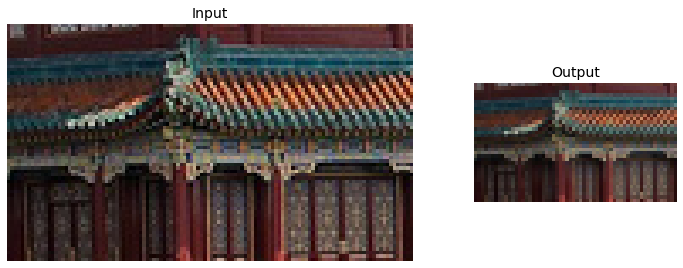

In [27]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### 2.3 Depth-wise pooling

Can also pool along the depth dimension rather than spatial dimensions (not as common)
- In theory, could allow CNN to learn to be invariant to various features
- _Examples_ : thickness, brightness, skewness, color, etc.

No depthwise max pool in keras, but one exists in `tf` low-level api $\to$ `tf.nn.max_pool()`

In [28]:
output = tf.nn.max_pool(images,
                       ksize = (1, 1, 1, 3),
                       strides = (1, 1, 1, 3),
                       padding = "VALID")

In [29]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [30]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Can also employ `Lambda` layer

In [31]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X,
                                                          ksize = (1, 1, 1, 3),
                                                         strides = (1, 1, 1, 3),
                                                         padding = "VALID"))

with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

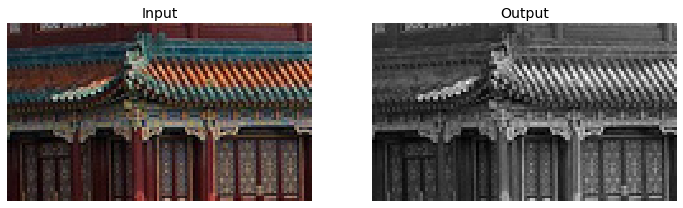

In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

### 2.4 Global average pool

Computes mean of the entire feature map; single number per feature map and per instance
- Extremely destructive, but potentially useful as the output layer

In [33]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

Equivalent representation as a `Lambda` layer

In [34]:
output_global_avg_2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis = [1, 2]))
output_global_avg_2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## 3. CNN Architectures

### 3.1 Fashion MNIST example

Most CNNs follow input $\to$ conv $\to$ pool $\to$ conv $\to \cdots \to$ pool $\to$ FC $\to \cdots$

__Performance notes__ :
- Common mistake to use kernels that are too large; instead of 5x5 kernel, stack two layers with 3x3 kernels
    - Fewer params, fewer computations, usually better performance
- Exception: first conv layer typically has large kernel, with small stride

In [35]:
# Load the data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [36]:
X_train.shape # 55k 28x28 grayscale images

(55000, 28, 28, 1)

In [24]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                       kernel_size = 3, activation = 'relu', padding = "SAME")

In [38]:
model = keras.models.Sequential([
    DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    keras.layers.MaxPooling2D(pool_size = 2),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 10, activation = "softmax")
])

In [ ]:
# Run the model -- need to use GPU
# model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
# history = model.fit(X_train, y_train, epochs = 10, validation_data = (X_valid, y_valid))
# score = model.evaluate(X_test, y_test)
# # X_new = X_test[:10] # pretend we have new images
# y_pred = model.predict(X_new)

### 3.2 ResNet-34

In [41]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [42]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64

# First 3 RU's have 64; next 4 have 128; etc.
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

### 3.3 Using a Pretrained Model

In [3]:
model = keras.applications.resnet50.ResNet50(weights = "imagenet")

#### 3.3.1 Aside: re-sizing images

In [4]:
images_resized = tf.image.resize(images, [224, 224])

This does not preserve the aspect ratio:

In [5]:
plot_color_image(images_resized[0])
plt.show()

NameError: name 'plot_color_image' is not defined

This preserves aspect ratio, and adds padding

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias = True)
plot_color_image(images_resized[0])

This crops to an appropriate size while keeping the ratio

In [ ]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

Alternatively, can manually specify the cropping

In [6]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()

NameError: name 'plot_color_image' is not defined

In [7]:
plot_color_image(images_resized[1])
plt.show()

NameError: name 'plot_color_image' is not defined

#### 3.3.2 Employing the pretrained network

In [8]:
# Rescale the image color inputs to [0, 255]
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

# Make predictions with ResNet
Y_proba = model.predict(inputs)

In [9]:
# Makes predictions for each of 1000 ResNet classes
Y_proba.shape

(2, 1000)

Display the top $K$ predictions, including class name and estimated probability:

In [10]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top = 3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



### 3.4 Pretrained Models for Transfer Learning

_Example_ : train model to classify pictures of flowers using pretrained Xception model

#### 3.4.1 Load and preprocess the data

In [13]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised = True, with_info = True)

In [18]:
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes # 5

In [20]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split = ["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised = True)

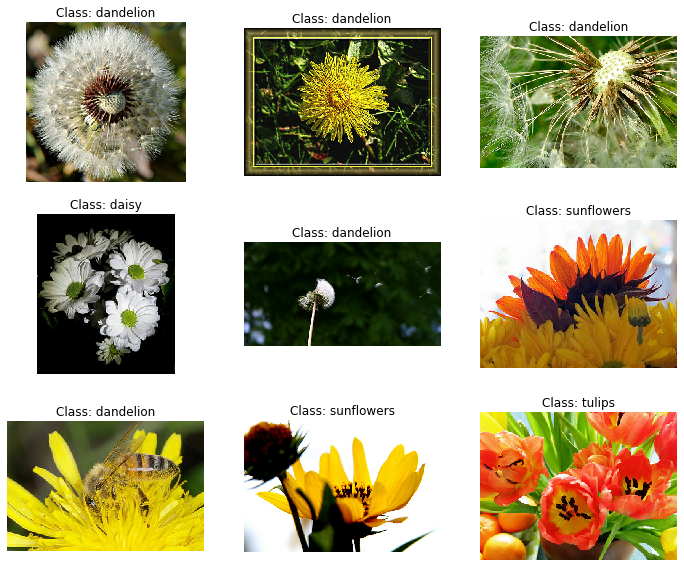

In [21]:
plt.figure(figsize = (12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    
plt.show()

Basic preprocessing:

In [22]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Fancier preprocessing for random crops -- some data augmentation

In [25]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# Apply preprocessing, shuffle the training set, and add batching + prefetching
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

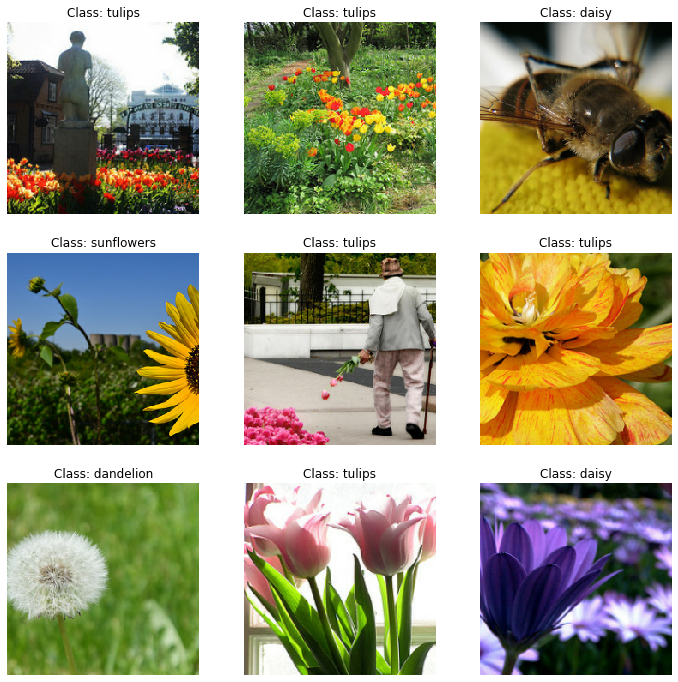

In [26]:
# Some train set images

plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

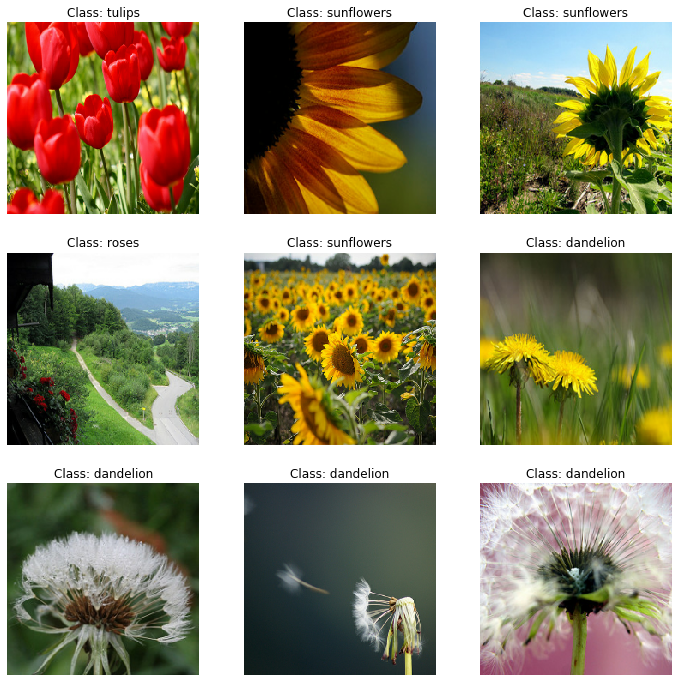

In [28]:
# Some test set images

plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

#### 3.4.2 Transfer learning

In [30]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [31]:
# Check on the layers

for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

Freeze the pretrained layers at beginning of training:

In [ ]:
# for layer in base_model.layers:
#     layer.trainable = False
    
# optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9, decay= 0.01)
# model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
# history = model.fit(train_set,
#                    steps_per_epoch = int(0.75 * dataset_size / batch_size),
#                    validation_data = valid_set,
#                    validation_steps = int(0.15 * dataset_size / batch_size),
#                    epochs = 40)